# Homework 4: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information Health Engineering, 2019-2020*

*Pablo M. Olmos olmos@tsc.uc3m.es*

*Iker Arana Abad 100344871@alumnos.uc3m.es*

*Natalia López Rojo 100418467@alumnos.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).

### 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 
* Normalize data if needed

In [0]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
from IPython.display import display


warnings.filterwarnings('ignore')




1.   Download and upload the dataset



In [0]:
uploaded = files.upload()

# we charge the csv into a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['HW4_data_csv.csv']))

# delete the last two columns
df.__delitem__('Unnamed: 10')
df.__delitem__('Unnamed: 11')
print(df)

# convert the dataframe into a numpy array 
data = pd.DataFrame(df).to_numpy()

"""
Specifically:
X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution
y1 Heating Load
y2 Cooling Load

"""


Saving HW4_data_csv.csv to HW4_data_csv (2).csv
       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


'\nSpecifically:\nX1 Relative Compactness\nX2 Surface Area\nX3 Wall Area\nX4 Roof Area\nX5 Overall Height\nX6 Orientation\nX7 Glazing Area\nX8 Glazing Area Distribution\ny1 Heating Load\ny2 Cooling Load\n\n'

In [0]:
# Dataset division into Data and Target Class partition
X = data[:,0:8]   # Data Partition
Y = data[:,8:10]  # Target Class Partition

2. Divide at random the dataset into train (80%) and test (20%) datasets

In [0]:
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

3. Data Normalization

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(f"\n Normalized data - mean: \n {X_train.mean(axis=0)}")
# print(f"\n Normalized data - variance: \n {X_train.std(axis=0)}")

In [0]:
feature_names= ['X1 Relative Compactness', 'X2 Surface Area', 'X3 Wall Area', 'X4 Roof Area', 'X5 Overall Height',
                'X6 Orientation', 'X7 Glazing Area', 'X8 Glazing Area Distribution']

model= ['Heating Load', 'Cooling Load']

**Plotting the Heating Load Model**

Heating Load Model


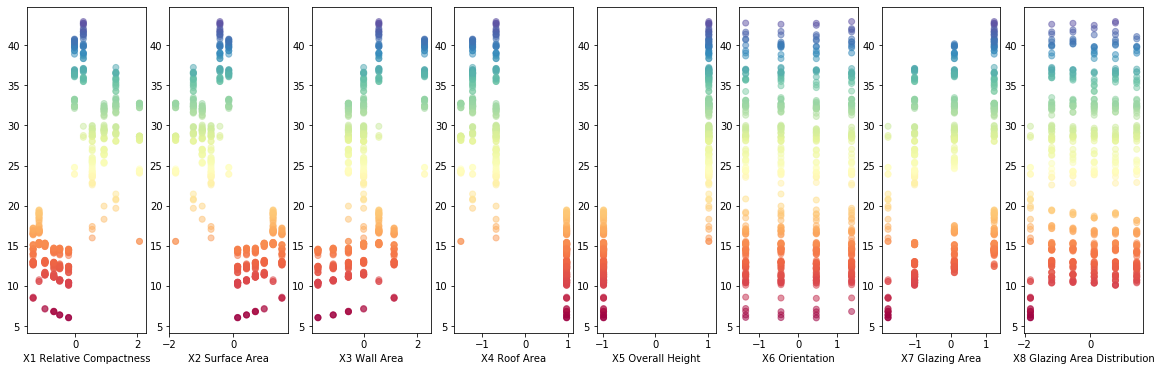

In [0]:
# Plot the ...
print('Heating Load Model')
plt.figure(figsize=(20,6))
for d in range(X_train.shape[1]):
    plt.subplot(1,8,d+1)
    plt.scatter(X_train[:, d], Y_train[:, :1], c=Y_train[:, :1], alpha=0.5,cmap='Spectral')
    plt.xlabel(feature_names[d])
plt.show()

**Plotting the Cooling Load Model**

Cooling Load Model


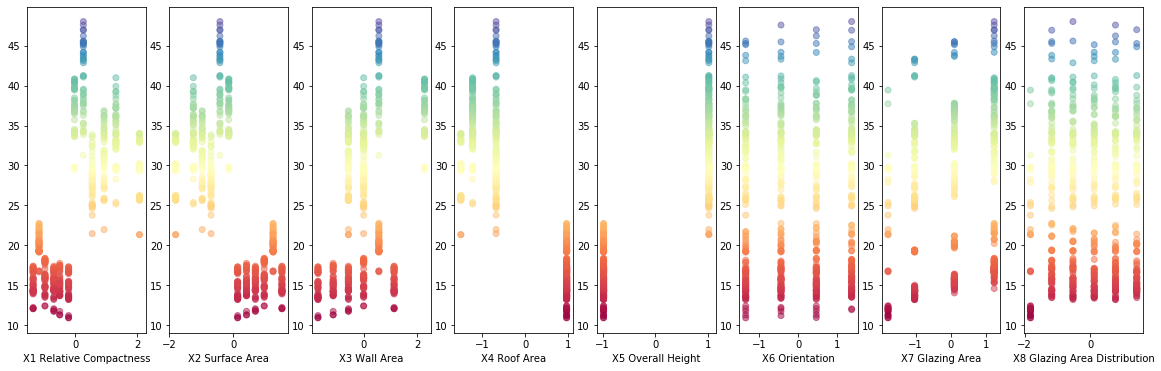

In [0]:
# Plot the ...
print('Cooling Load Model')
plt.figure(figsize=(20,6))
for d in range(X_train.shape[1]):
    plt.subplot(1,8,d+1)
    plt.scatter(X_train[:, d], Y_train[:, 1:], c=Y_train[:, 1:], alpha=0.5,cmap='Spectral')
    plt.xlabel(feature_names[d])
plt.show()

### 2. Setting and optimizing the model

You will train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs ...

**On the training data set:**

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term. 

b) Fit the covariance function parameters and noise variance. 

c) According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) 

**On the test data set:**

d) Compute the test mean absolute error error and the test mean square error (MSE)  using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X).


2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define different kernels and combine  them. Comments the results. 





---



In [0]:
# You can also install GPy using the following command (Works on Windows!)

!pip install GPy 

     |████████████████████████████████| 1.0MB 6.3MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633997 sha256=4ee33628ebd3cbafb6b26ca6054540368956f9e7d50f5aee7ec9405b18adc8af
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=b7c2b8044b58872ca75604f2d15a6f4615c67be65f6f250c639c047c9b2d3ca5
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
import GPy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]



---




We will train **two independent GPs** one to estimate HL and one to estimate CL. 

# Part 1 - The ''m_HL'' model 
## 1.1 On the training data set: 
***First***, built a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term.

**KERNEL**

Using the parameter `ARD=True` the lenghtscale of the regression model are assumed to be different for each input dimension.

In [0]:
kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True) + GPy.kern.White(input_dim=X_train.shape[1])
print(kernel)

  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |   (8,)  |      +ve      |        
  white.variance   |    1.0  |      +ve      |        


**Starting values**

In [0]:
print(f"\n Kernel parameters: \n {kernel.parameter_names()}")
print(f"\n Variance of the kernel=RBF: \n {kernel.rbf.variance.values}")
print(f"\n Lengthscale values for the kernel=RBF: \n {kernel.rbf.lengthscale.values}")
print(f"\n White Noise variance for the kernel=White: \n {kernel.white.variance.values}")


 Kernel parameters: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Variance of the kernel=RBF: 
 [1.]

 Lengthscale values for the kernel=RBF: 
 [1. 1. 1. 1. 1. 1. 1. 1.]

 White Noise variance for the kernel=White: 
 [1.]


We will have an lenghtscale array with eight elements as we have one possible value per input dimension. At the beginning, we will have the values initialized to 1. After the optimization, the lenghtscale values will adjust to the data.

***Secondly***, fit the covariance function (KERNEL) parameters and noise variance.

**MODEL**

Due to the lack of information a priori about the data we have, it is not possible to fix any constraints

In [0]:
m_HL = GPy.models.GPRegression(X_train,Y_train[:, :1],kernel)

This model is initialized with incorrect lengthscale and variance, so let's optimize it.

**OPTIMIZATION**

In [0]:
print('Regression Model before optimization:')
print (m_HL) # preferred rather than display(model)
print("")

print(m_HL.optimize_restarts(num_restarts = 15, messages=False))

print("")
print('Regression Model after optimization:')
print (m_HL)

Regression Model before optimization:

Name : GP regression
Objective : 504.81389898626844
Number of Parameters : 11
Number of Optimization Parameters : 11
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  sum.rbf.variance         |      2321.910961966257  |      +ve      |        
  sum.rbf.lengthscale      |                   (8,)  |      +ve      |        
  sum.white.variance       |    0.18545066993144166  |      +ve      |        
  Gaussian_noise.variance  |  6.698237457254693e-61  |      +ve      |        

Optimization restart 1/15, f = 504.8138989754125
Optimization restart 2/15, f = 671.1523454206674
Optimization restart 3/15, f = 620.5759812984021
Optimization restart 4/15, f = 526.007169953728
Optimization restart 5/15, f = 569.9340022579044
Optimization restart 6/15, f = 521.4186290758847
Optimization restart 7/15, f = 610.0015075434048
Optimization restart 8/15, f = 782.423916235741
Optimization restart 9/15, f = 

Now our parameters have been optimised to the values that give the largest marginal likelihood.

**Optimized values**

In [0]:
print(f"\n Kernel parameters: \n {kernel.parameter_names()}")
print(f"\n Variance of the kernel=RBF: \n {kernel.rbf.variance.values}")
print(f"\n Lengthscale values for the kernel=RBF: \n {kernel.rbf.lengthscale.values}")
print(f"\n White Noise variance for the kernel=White: \n {kernel.white.variance.values}")


 Kernel parameters: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Variance of the kernel=RBF: 
 [2321.9109623]

 Lengthscale values for the kernel=RBF: 
 [   3.11843402  509.56659122    1.57249616  552.59842579    4.73611855
 1389.68144121    3.31896913  310.08037282]

 White Noise variance for the kernel=White: 
 [0.18544964]


If we plot the lenghtscale values after the optimization we can observe great differences between the different features of the model.

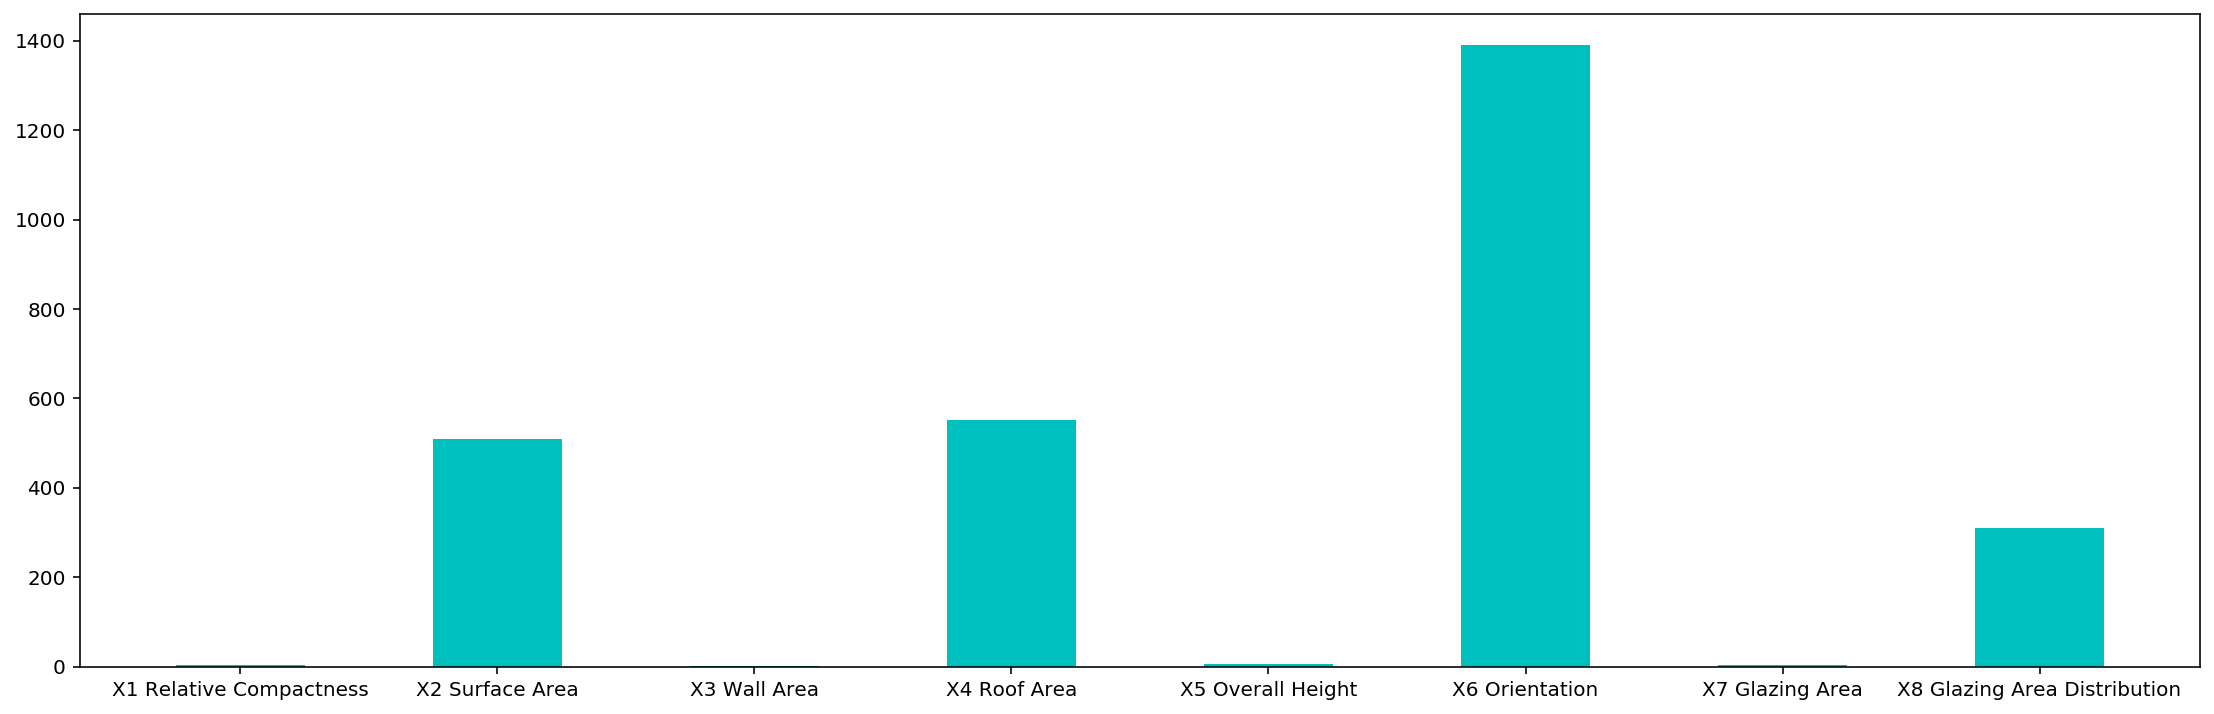

In [0]:
x= np.arange(1, 9, 1)
plt.figure(figsize=(19,6))
height= kernel.rbf.lengthscale.values
plt.bar(feature_names, height, width=0.5, color='c')
plt.show()


***Third***, According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the paper

**The lenght scale and the importance of a feature is not directly related.** However, it can be assumed that hyper parameters can tell something about the importance about the feature. If the hyper parameter of a certain feature is small, only a small change in that feature would cause very different output value. Assuming that we take this input feature out from the input vector, the variance of the model would increase (or prediction accuracy decrease a lot). 




> PAPER - TABLE 8 : *the importance results in Table 8 suggest that X7 (glazing
area) is the most important predictor for both HL and CL.*



In [0]:
print(kernel.rbf.lengthscale)

  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |  priors
  [0]    |                         3.11843402  |      +ve      |        
  [1]    |                       509.56659122  |      +ve      |        
  [2]    |                         1.57249616  |      +ve      |        
  [3]    |                       552.59842579  |      +ve      |        
  [4]    |                         4.73611855  |      +ve      |        
  [5]    |                      1389.68144121  |      +ve      |        
  [6]    |                         3.31896913  |      +ve      |        
  [7]    |                       310.08037282  |      +ve      |        


According to what we mentioned, if we look at the table the most relevant features are the following ones: 

*   X3 Wall Area
*   X7 Glazing Area
*   X1 Relative Compactness



The main reason that could explain why we obtained different results in comparison to the paper coyld rely in the fact that we are using **different metrics**. During this course, we have learnt several algorithms that have helped us to predict the data. Although algorithms provide similar prediction results, the way in which they obtain the final prediction is different cause it is dependent on the metrics they use. For so, it is possible that the algorithms used along the paper gave more importance to some features that are not the same to the ones we have obtained using GPy and RBF kernel. 

## 1.2 On the test data set

***Firslty***, Compute the test mean absolute error (MAE) and the test mean square error (MSE) using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the paper.




> PAPER -  TABLE 5 and TABLE 5:  

*   MSE: 9.87 ± 2.41 (IRIS classifier) 1.03 ± 0.54 (RF classifier)
*   MAE: 2.14 ± 0.24 (IRIS classifier) 0.51 ± 0.11 (RF classifier)

The results are given in the form mean ± standard deviation.



In [0]:
nsamples= X_train.shape[0]

## PREDICTION
Y_pred_mean, Cov= m_HL.predict(X_test, full_cov=True)

## METRICS
MSE= metrics.mean_squared_error(y_test[:, :1], Y_pred_mean)
MAE= metrics.mean_absolute_error(y_test[:, :1], Y_pred_mean)

print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 0.2779041826863891
The MAE is: 0.3592039318812957


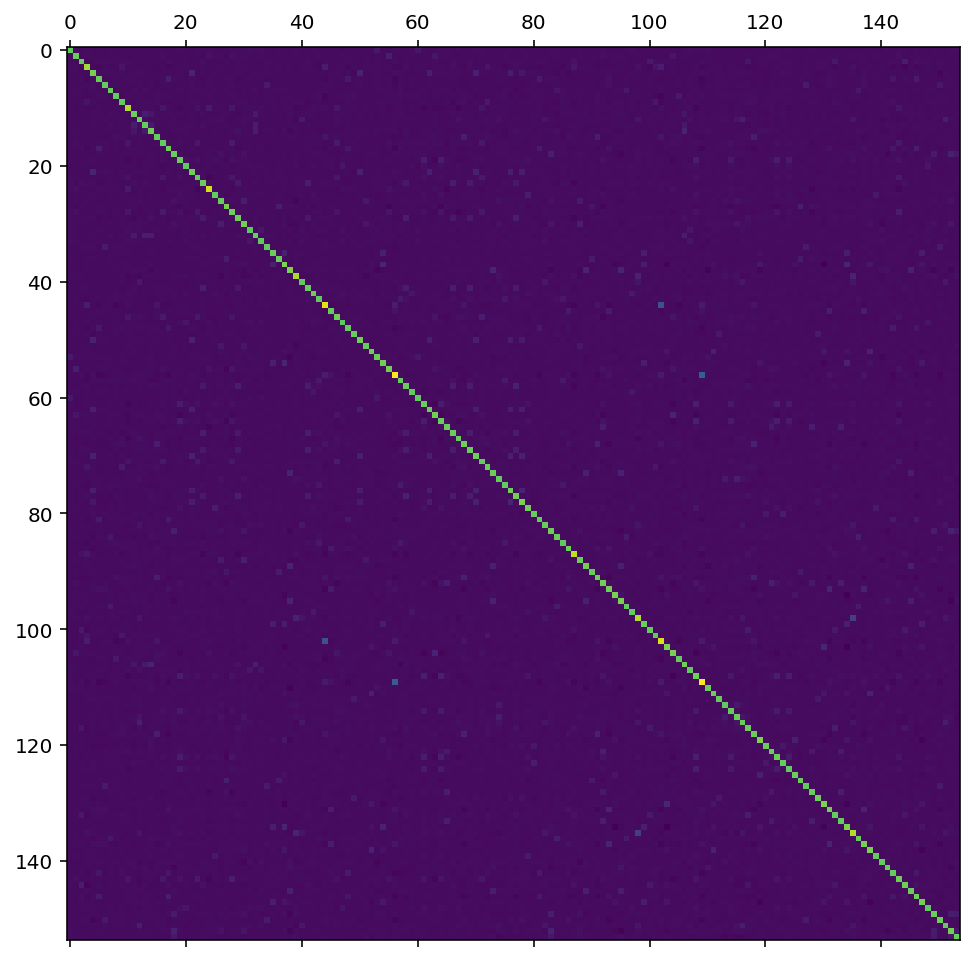

In [0]:
# Cov.shape --> (154, 154) being 154 the number of TEST points
plt.matshow(Cov) 
plt.show()

***Secondly***, Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this link you can see how to define different kernels and combine them. Comments the results.



* RBF: *Radial Basis Function kernel, aka squared-exponential, exponentiated quadratic or Gaussian kernel*: 

  Formula: $k(r) = \sigma^2 \exp (-\frac{1}{2} r^2)$

* Matern32:  *matern kernel is a generalization of the RBF and the absolute exponential kernel parameterized by an additional parameter nu. The smaller nu, the less smooth the approximated function is.* 

  Formula: $k(r) = \sigma^2 (1 + \sqrt{3} r) \exp(- \sqrt{3} r)$ where $r = \sqrt{\sum_{i=1}^{\text{input_dim}} \frac{(x_i-y_i)^2}{\ell_i^2} }$


* ExpQuad: *The Exponentiated quadratic covariance function.*

  Formula: $k(r) = \sigma^2 (1 + \sqrt{5} r + \frac53 r^2) \exp(- \sqrt{5} r)$


In [0]:
## KERNELS
k1 = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
k2 = GPy.kern.Matern32(input_dim=X_train.shape[1], ARD=True)
k3 = GPy.kern.ExpQuad(input_dim=X_train.shape[1], ARD=True)  

## OPERATION OVER KERNELS
# Sum of kernels
k_add_1 = k1 + k2
k_add_2 = k1 + k3

# Product of kernels
k_prod_1 = k1 *k2
k_prod_2 = k1 *k3

In [0]:
m_HL_k1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k1)
m_HL_k2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k2)
m_HL_k3 = GPy.models.GPRegression(X_train,Y_train[:, :1],k3)

m_HL_k_add_1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_add_1)
m_HL_k_add_2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_add_2)

m_HL_k_prod_1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_prod_1)
m_HL_k_prod_2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_prod_2)

In [0]:
print('Init')

m_HL_k1.optimize_restarts(num_restarts = 5)
m_HL_k2.optimize_restarts(num_restarts = 5)
m_HL_k3.optimize_restarts(num_restarts = 5)

m_HL_k_add_1.optimize_restarts(num_restarts = 5)
m_HL_k_add_2.optimize_restarts(num_restarts = 5)

m_HL_k_prod_1.optimize_restarts(num_restarts = 5)
m_HL_k_prod_2.optimize_restarts(num_restarts = 5)

print('End')

Init
Optimization restart 1/5, f = 639.0179814320322
Optimization restart 2/5, f = 506.7126296433417
Optimization restart 3/5, f = 591.5807785515218
Optimization restart 4/5, f = 520.0746797151812
Optimization restart 5/5, f = 523.3268454630154
Optimization restart 1/5, f = 511.5019917945388
Optimization restart 2/5, f = 505.4071838990397
Optimization restart 3/5, f = 511.49360790784704
Optimization restart 4/5, f = 511.5004342698878
Optimization restart 5/5, f = 511.5002505514593
Optimization restart 1/5, f = 639.0179814320322
Optimization restart 2/5, f = 748.395413825996
Optimization restart 3/5, f = 606.0966555604075
Optimization restart 4/5, f = 513.2676459628543
Optimization restart 5/5, f = 523.0653831954089
Optimization restart 1/5, f = 410.5237532599046
Optimization restart 2/5, f = 483.0369761513394
Optimization restart 3/5, f = 533.5002928860106
Optimization restart 4/5, f = 525.8992560059644
Optimization restart 5/5, f = 462.37271002182683
Optimization restart 1/5, f = 561.

In [0]:
nsamples= X_train.shape[0]
models= [m_HL_k1, m_HL_k2, m_HL_k3, m_HL_k_add_1, m_HL_k_add_2, m_HL_k_prod_1, m_HL_k_prod_2]

MSE_m= []
MAE_m= []

for model in models:
    Y_pred_mean, Cov= model.predict(X_test, full_cov=True)
    MSE_m.append(metrics.mean_squared_error(y_test[:, :1], Y_pred_mean))
    MAE_m.append(metrics.mean_absolute_error(y_test[:, :1], Y_pred_mean))

The final results for each one of those models are the following:

In [0]:
models0= ['RBF',' Matern32', 'ExpQuad', 'RBF + Matern32', 'RBF + ExpQuad', 'RBF x Matern32', 'RBF x ExpQuad']
dataframe=pd.DataFrame(models0, columns=['Models'])
dataframe['MSE']= np.asarray(MSE_m).ravel()
dataframe['MAE']= np.asarray(MAE_m).ravel()
dataframe.head(10)

,Models,MSE,MAE
0,RBF,0.278573,0.360037
1,Matern32,0.190887,0.277202
2,ExpQuad,0.278540,0.363228
3,RBF + Matern32,0.217063,0.293024
4,RBF + ExpQuad,0.293039,0.366506
5,RBF x Matern32,0.234116,0.309943
6,RBF x ExpQuad,0.277179,0.360796


The results using the kernel defined in the previous section were the following:

In [0]:
print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 0.2779041826863891
The MAE is: 0.3592039318812957


If we compare the results, we could affirm that using the **Matern32** kernel could provide better results in comparison to the ones we obtained using the initial kernel. Nonetheless,  we have also to take into account that this time we have not included noise into the GP so the results might not be similar if we add noise. 


---

# Part 2 - The ''m_CL'' model
## 2.1 On the training data set
***First***, built a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term.

**KERNEL**

Using the parameter `ARD=True` the lenghtscale of the regression model are assumed to be different for each input dimension.

In [0]:
kernel_1 = GPy.kern.RBF(input_dim=X_train.shape[1],ARD=True) + GPy.kern.White(input_dim=X_train.shape[1])
print(kernel_1)

  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |   (8,)  |      +ve      |        
  white.variance   |    1.0  |      +ve      |        


**Starting values**

In [0]:
print(f"\n Kernel parameters: \n {kernel_1.parameter_names()}")
print(f"\n Variance of the kernel=RBF: \n {kernel_1.rbf.variance.values}")
print(f"\n Lengthscale values for the kernel=RBF: \n {kernel_1.rbf.lengthscale.values}")
print(f"\n White Noise variance for the kernel=White: \n {kernel_1.white.variance.values}")


 Kernel parameters: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Variance of the kernel=RBF: 
 [1.]

 Lengthscale values for the kernel=RBF: 
 [1. 1. 1. 1. 1. 1. 1. 1.]

 White Noise variance for the kernel=White: 
 [1.]


We will have an lenghtscale array with eight elements as we have one possible value per input dimension. At the beginning, we will have the values initialized to 1. After the optimization, the lenghtscale values will adjust to the data.

***Secondly***, fit the covariance function parameters and noise variance.

**MODEL**

In [0]:
m_CL = GPy.models.GPRegression(X_train,Y_train[:, 1:],kernel_1)

**OPTIMIZATION**

In [0]:
print('Regression Model before optimization:')
print (m_CL)
print("")

# print("\n Optimizacion para variable de salida HL: \n")
print(m_CL.optimize_restarts(num_restarts = 15))

print("")
print('Regression Model after optimization:')
print (m_CL)

Regression Model before optimization:

Name : GP regression
Objective : 13092.60858974557
Number of Parameters : 11
Number of Optimization Parameters : 11
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |   (8,)  |      +ve      |        
  sum.white.variance       |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Optimization restart 1/15, f = 1227.146910778981
Optimization restart 2/15, f = 1230.8766152944754
Optimization restart 3/15, f = 1229.875169224157
Optimization restart 4/15, f = 1230.3460015556882
Optimization restart 5/15, f = 1230.3188827049535
Optimization restart 6/15, f = 1291.9142338124889
Optimization restart 7/15, f = 1283.078700861952
Optimization restart 8/15, f = 1231.348148304592
Optimization restart 9/15, f = 1355.8349857286712
Optimization restart 10/15, f = 1230.3719300190885
Optim

**Optimized values**

In [0]:
print(f"\n Kernel parameters: \n {kernel_1.parameter_names()}")
print(f"\n Variance of the kernel=RBF: \n {kernel_1.rbf.variance.values}")
print(f"\n Lengthscale values for the kernel=RBF: \n {kernel_1.rbf.lengthscale.values}")
print(f"\n White Noise variance for the kernel=White: \n {kernel_1.white.variance.values}")


 Kernel parameters: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Variance of the kernel=RBF: 
 [782.85440597]

 Lengthscale values for the kernel=RBF: 
 [1.94491255e+00 4.78800159e+03 1.19804368e+00 1.29269386e+02
 3.51901452e+00 2.26804734e+02 1.24966934e+01 5.75049656e+02]

 White Noise variance for the kernel=White: 
 [1.39650596e-190]


If we plot the lenghtscale values after the optimization we can observe great differences between the different features of the model.

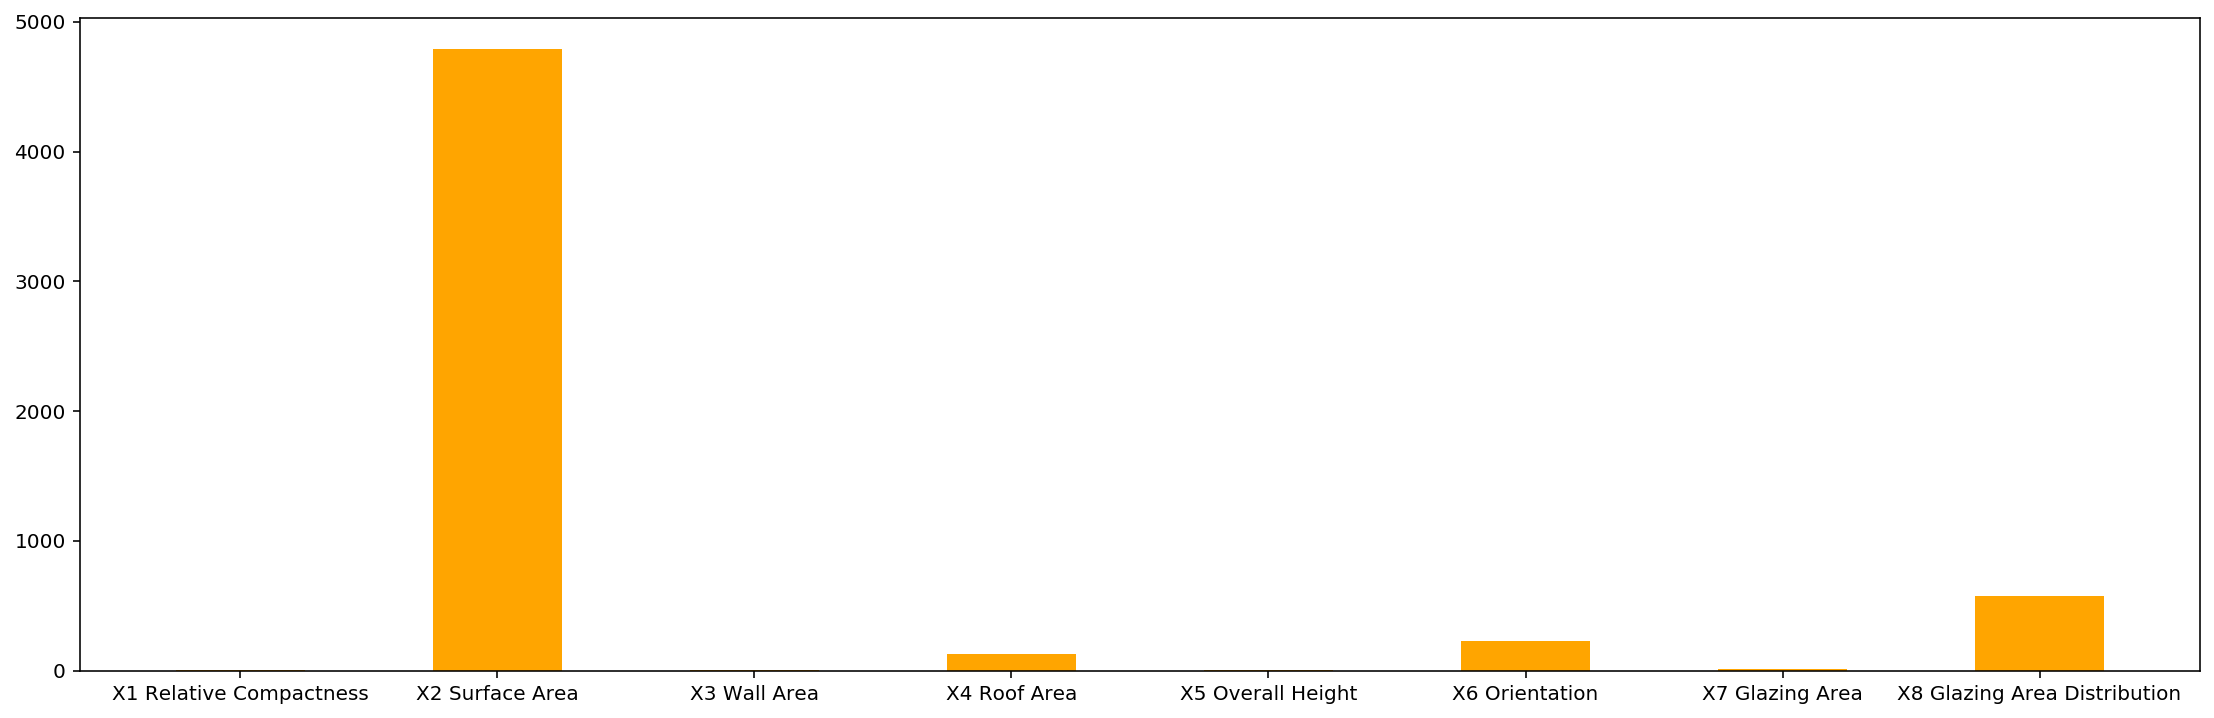

In [0]:
x= np.arange(1, 9, 1)
plt.figure(figsize=(19,6))
height= kernel_1.rbf.lengthscale.values
plt.bar(feature_names, height, width=0.5, color='orange')
plt.show()


***Third***, According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the paper

**The lenght scale and the importance of a feature is not directly related.** However, it can be assumed that hyper parameters can tell something about the importance about the feature. If the hyper parameter of a certain feature is small, only a small change in that feature would cause very different output value. Assuming that we take this input feature out from the input vector, the variance of the model would increase (or prediction accuracy decrease a lot). 




> PAPER - TABLE 8 : *the importance results in Table 8 suggest that X7 (glazing
area) is the most important predictor for both HL and CL.*



In [0]:
print(kernel_1.rbf.lengthscale)

  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |  priors
  [0]    |                         1.94491255  |      +ve      |        
  [1]    |                      4788.00158642  |      +ve      |        
  [2]    |                         1.19804368  |      +ve      |        
  [3]    |                       129.26938633  |      +ve      |        
  [4]    |                         3.51901452  |      +ve      |        
  [5]    |                       226.80473354  |      +ve      |        
  [6]    |                        12.49669344  |      +ve      |        
  [7]    |                       575.04965636  |      +ve      |        


According to what we mentioned, if we look at the table the most relevant features are the following ones: 

*   X3 Wall Area
*   X1 Relative Compactness
*   X7 Glazing Area



The important features obtained in the prediction of the label Heating Load (HL) are the **same to the ones obtained in the prediction of the label Cooling Load** except for the lengthscale values that as expected are dependent of the model. Besides, we want to mention that the feature X2 Surface Area in both models m_HL and m_CL has a large lenghtscale. So, it would be also interesting to discard these value as it not quite relevant in comparison with the other features.

## 2.2. On the test data set

***Firstlty***, Compute the test mean absolute error error and the test mean square error (MSE) using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the paper.



> PAPER -  TABLE 5 and TABLE 5:  

*   MSE: 11.46 ± 3.63 (IRIS classifier) 6.59 ± 1.56 (RF classifier)
*   MAE: 2.21 ± 0.28 (IRIS classifier) 1.42 ± 0.25 (RF classifier)

The results are given in the form mean ± standard deviation.



In [0]:
nsamples= X_train.shape[0]

## PREDICTION
nsamples= X_train.shape[0]
mean, Cov= m_CL.predict(X_test,full_cov=True)

## METRICS
MSE= metrics.mean_squared_error(y_test[:, 1:], mean)
MAE= metrics.mean_absolute_error(y_test[:, 1:], mean)

print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 3.3609085769301994
The MAE is: 1.2201245070497382


***Secondly***, Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this link you can see how to define different kernels and combine them. Comments the results.

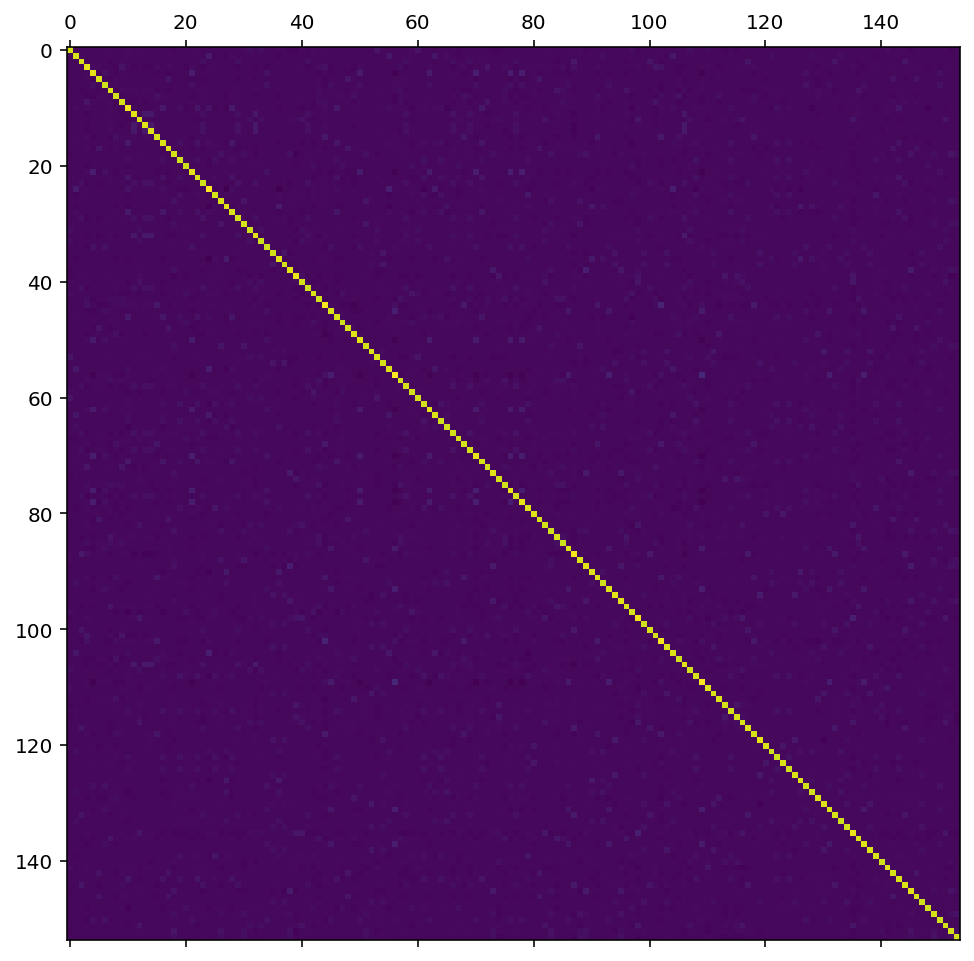

In [0]:
# Cov.shape --> (154, 154) being 154 the number of TEST points
plt.matshow(Cov) 
plt.show()

***Secondly***, Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this link you can see how to define different kernels and combine them. Comments the results.

In [0]:
## KERNELS
k1 = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
k2 = GPy.kern.Matern32(input_dim=X_train.shape[1], ARD=True)
k3 = GPy.kern.ExpQuad(input_dim=X_train.shape[1], ARD=True)  

## OPERATION OVER KERNELS
# Sum of kernels
k_add_1 = k1 + k2
k_add_2 = k1 + k3

# Product of kernels
k_prod_1 = k1 *k2
k_prod_2 = k1 *k3

In [0]:
m_HL_k1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k1)
m_HL_k2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k2)
m_HL_k3 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k3)

m_HL_k_add_1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_add_1)
m_HL_k_add_2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_add_2)

m_HL_k_prod_1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_prod_1)
m_HL_k_prod_2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_prod_2)

In [0]:
print('Init')

m_HL_k1.optimize_restarts(num_restarts = 5)
m_HL_k2.optimize_restarts(num_restarts = 5)
m_HL_k3.optimize_restarts(num_restarts = 5)

m_HL_k_add_1.optimize_restarts(num_restarts = 5)
m_HL_k_add_2.optimize_restarts(num_restarts = 5)

m_HL_k_prod_1.optimize_restarts(num_restarts = 5)
m_HL_k_prod_2.optimize_restarts(num_restarts = 5)

print('End')

Init
Optimization restart 1/5, f = 1227.8907069411234
Optimization restart 2/5, f = 1227.2389255271385
Optimization restart 3/5, f = 1229.672355027386
Optimization restart 4/5, f = 1229.93050431732
Optimization restart 5/5, f = 1226.8486153009294
Optimization restart 1/5, f = 927.489810400464
Optimization restart 2/5, f = 927.4887192961883
Optimization restart 3/5, f = 927.4897861699428
Optimization restart 4/5, f = 927.4896422148331
Optimization restart 5/5, f = 927.4920855203885
Optimization restart 1/5, f = 1227.8907069411234
Optimization restart 2/5, f = 1229.6941254701605
Optimization restart 3/5, f = 1230.2855285510582
Optimization restart 4/5, f = 1354.3772065362878
Optimization restart 5/5, f = 1226.8591961926677
Optimization restart 1/5, f = 869.9978773633592
Optimization restart 2/5, f = 873.9044901105556
Optimization restart 3/5, f = 912.8355974557471
Optimization restart 4/5, f = 926.7076579783286
Optimization restart 5/5, f = 802.4406687489513
Optimization restart 1/5, f =

In [0]:
nsamples= X_train.shape[0]
models= [m_HL_k1, m_HL_k2, m_HL_k3, m_HL_k_add_1, m_HL_k_add_2, m_HL_k_prod_1, m_HL_k_prod_2]

MSE_mm= []
MAE_mm= []

for model in models:
    Y_pred_mean, Cov= model.predict(X_test, full_cov=True)
    MSE_mm.append(metrics.mean_squared_error(y_test[:, 1:], Y_pred_mean))
    MAE_mm.append(metrics.mean_absolute_error(y_test[:, 1:], Y_pred_mean))

In [0]:
models0= ['RBF',' Matern32', 'ExpQuad', 'RBF + Matern32', 'RBF + ExpQuad', 'RBF x Matern32', 'RBF x ExpQuad']
dataframe=pd.DataFrame(models0, columns=['Models'])
dataframe['MSE']= np.asarray(MSE_mm).ravel()
dataframe['MAE']= np.asarray(MAE_mm).ravel()
dataframe.head(10)

,Models,MSE,MAE
0,RBF,3.360620,1.220029
1,Matern32,0.299502,0.404508
2,ExpQuad,3.360379,1.219571
3,RBF + Matern32,0.142513,0.258125
4,RBF + ExpQuad,0.304050,0.421753
5,RBF x Matern32,0.375441,0.414374
6,RBF x ExpQuad,0.464980,0.492583


The results using the kernel defined in the previous section were the following:

In [0]:
print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 3.3609085769301994
The MAE is: 1.2201245070497382


If we compare the results, we could affirm that again using the **Matern32** kernel could provide much better results in comparison to the ones we obtained using the initial kernel. But, as we previously mention we should keep in mind that we have not included noise into these GP so the results might not be similar if we add noise. 

To sum up, it seems that according to our data the use of Matern32 kernel could provide really good results.

# Part 3 - Sparse GP implementation 

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points. 

SparseGP aims at selecting a subset of points to represent the GP and lower down its complexity, since future prediction won't rely on the entire dataset.

**INDUCING POINTS**
  

*   a set of points lying in the same input space with corresponding values in the output space
*   summarise the characteristics of the function using less points than the training data



The following code aims to compute the Sparse GP implementation using different inducing points (20, 40 and 100). We found easier to compute everything in the same loop so in order to faciliate the comprehension, we have added some comments for a better understanding. 

In [0]:
inducingPoints_ = [20, 40, 100]

MSE_m_CL_X_after= []
MSE_m_HL_X_after= []

MSE_m_CL_X_before= []
MSE_m_HL_X_before= []


for numInducingPoints in inducingPoints_: 

    print('')
    print('*******************************************************')
    print('The number of inducing points is:', numInducingPoints)
    print('')

    ## SPARSE GAUSSIAN PROCESS
    # GPy kernel: defaults to rbf+white
    # num_inducing: number of inducing points
    # If no Z array is passed, num_inducing points are selected from the data.
    m_CL_X = GPy.models.SparseGPRegression(X_train,Y_train[:, 1:], num_inducing=numInducingPoints)
    m_HL_X = GPy.models.SparseGPRegression(X_train,Y_train[:, :1], num_inducing=numInducingPoints)
    # NUMBER OF HYPERPARAMETERS: number of inducing points x input_dimension + rbf.variance + rbf.lengthscale + Gaussian_noise.variance

    ## FIX A CONTRAINT RELATED TO THE INDUCING POINTS
    # Constrain the inducing_inputs parameter to be fixed to the current value it carries.
    # This does not override the previous constraints, so unfixing will
    # restore the constraint set before fixing.
    m_CL_X.inducing_inputs.fix()
    m_HL_X.inducing_inputs.fix()

    ## OPTIMIZING COVARIANCE PARAMETERS
    # It does NOT modify the inducing points
    # Optimize the following parameters: rbf.variance, rbf.lengthscale, Gaussian_noise.variance
    print('Optimization - inducing points CONSTRAINED')
    print('model m_CL')
    m_CL_X.optimize('bfgs', max_iters=1000)
    print('model m_HL')
    m_HL_X.optimize('bfgs', max_iters=1000)

    ## MSE ERROR: MODEL OPTIMIZED AND NO CHANGES IN INDUCING POINTS
    mu_CL, var = m_CL_X.predict(X_test, full_cov=True) 
    MSE_m_CL_X_after.append(metrics.mean_squared_error(y_test[:, 1:], mu_CL))

    mu_HL, var = m_HL_X.predict(X_test, full_cov=True) 
    MSE_m_HL_X_after.append(metrics.mean_squared_error(y_test[:, :1], mu_HL))

    ## OPTIMIZING INDUCING POINTS
    # randomize
    m_CL_X.randomize()
    m_HL_X.randomize()

    # m.Z.unconstrain() inducing_inputs
    m_CL_X.inducing_inputs.unconstrain() 
    m_HL_X.inducing_inputs.unconstrain()

    # optimize
    print('')
    print('Optimization - inducing points NOT CONSTRAINED')
    print('model m_CL')
    m_CL_X.optimize('bfgs', max_iters=1000)
    print('model m_HL')
    m_HL_X.optimize('bfgs', max_iters=1000)

    ## MSE ERROR: MODEL OPTIMIZED AND CHANGES IN INDUCING POINTS
    mu_CLL, var = m_CL_X.predict(X_test, full_cov=True) 
    MSE_m_CL_X_before.append(metrics.mean_squared_error(y_test[:, 1:], mu_CLL))

    mu_HLL, var = m_HL_X.predict(X_test, full_cov=True) 
    MSE_m_HL_X_before.append(metrics.mean_squared_error(y_test[:, :1], mu_HLL))


*******************************************************
The number of inducing points is: 20

Optimization - inducing points CONSTRAINED
model m_CL
model m_HL

Optimization - inducing points NOT CONSTRAINED
model m_CL
model m_HL

*******************************************************
The number of inducing points is: 40

Optimization - inducing points CONSTRAINED
model m_CL
model m_HL

Optimization - inducing points NOT CONSTRAINED
model m_CL
model m_HL

*******************************************************
The number of inducing points is: 100

Optimization - inducing points CONSTRAINED
model m_CL
model m_HL

Optimization - inducing points NOT CONSTRAINED
model m_CL
model m_HL


**Heating Load Model**

In [0]:
print('IP refers to Inducing Points')
print('')
dataframe=pd.DataFrame(inducingPoints_, columns=['HL Model - IP    '])
dataframe['MSE with IP Constrained     ']= np.asarray(MSE_m_HL_X_before).ravel()
dataframe['MSE with IP Not Constrained']= np.asarray(MSE_m_HL_X_after).ravel()
dataframe.head(len(inducingPoints_))

IP refers to Inducing Points



,HL Model - IP,MSE with IP Constrained,MSE with IP Not Constrained
0,20,7.256361,8.366738
1,40,5.474220,4.893204
2,100,1.169338,0.770487


Plotting the results, we end up having the following figure:

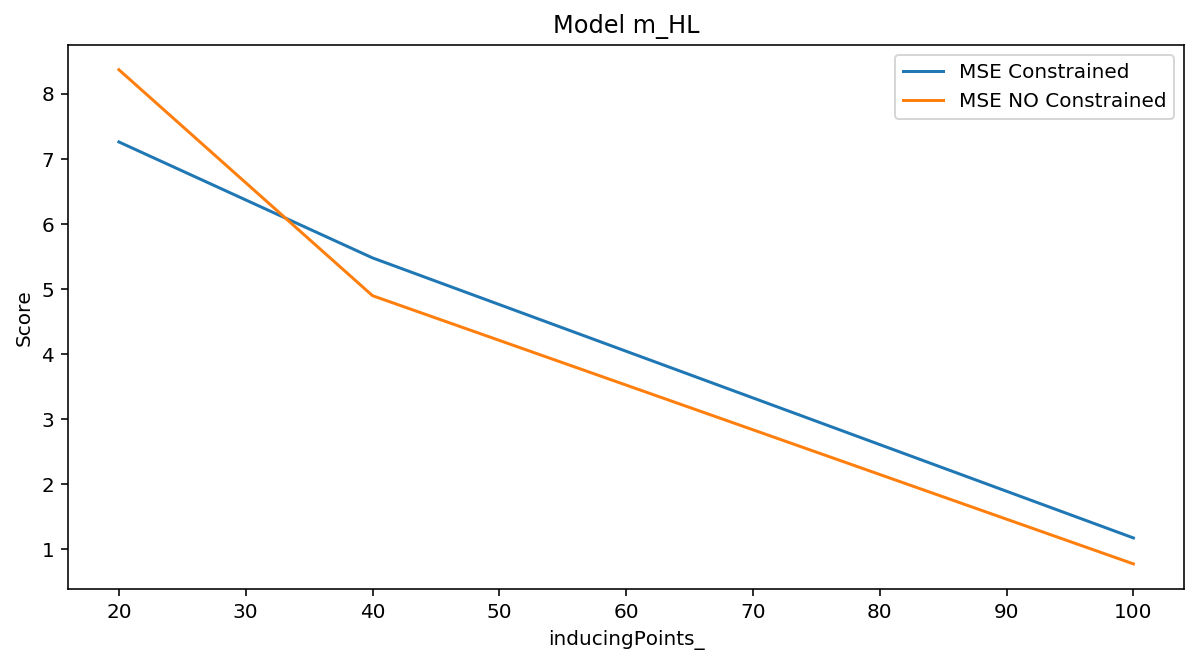

In [0]:
plt.figure(figsize=(10,5))
plt.plot(inducingPoints_, MSE_m_HL_X_before, label='MSE Constrained')
plt.plot(inducingPoints_, MSE_m_HL_X_after, label='MSE NO Constrained')
plt.xlabel('inducingPoints_')
plt.ylabel('Score')
plt.legend()
plt.title('Model m_HL')
plt.show()

**Cooling Load Model**

The final results of all the entire process Sparse GP will be the following:

In [0]:
print('IP refers to Inducing Points')
print('')
dataframe=pd.DataFrame(inducingPoints_, columns=['CL Model - IP   '])
dataframe['MSE with IP Constrained     ']= np.asarray(MSE_m_CL_X_before).ravel()
dataframe['MSE with IP Not Constrained']= np.asarray(MSE_m_CL_X_after).ravel()
dataframe.head(len(inducingPoints_))

IP refers to Inducing Points



,CL Model - IP,MSE with IP Constrained,MSE with IP Not Constrained
0,20,9.043218,9.710519
1,40,7.459132,7.283448
2,100,4.403287,3.908590


Plotting the results, we end up having the following figure:

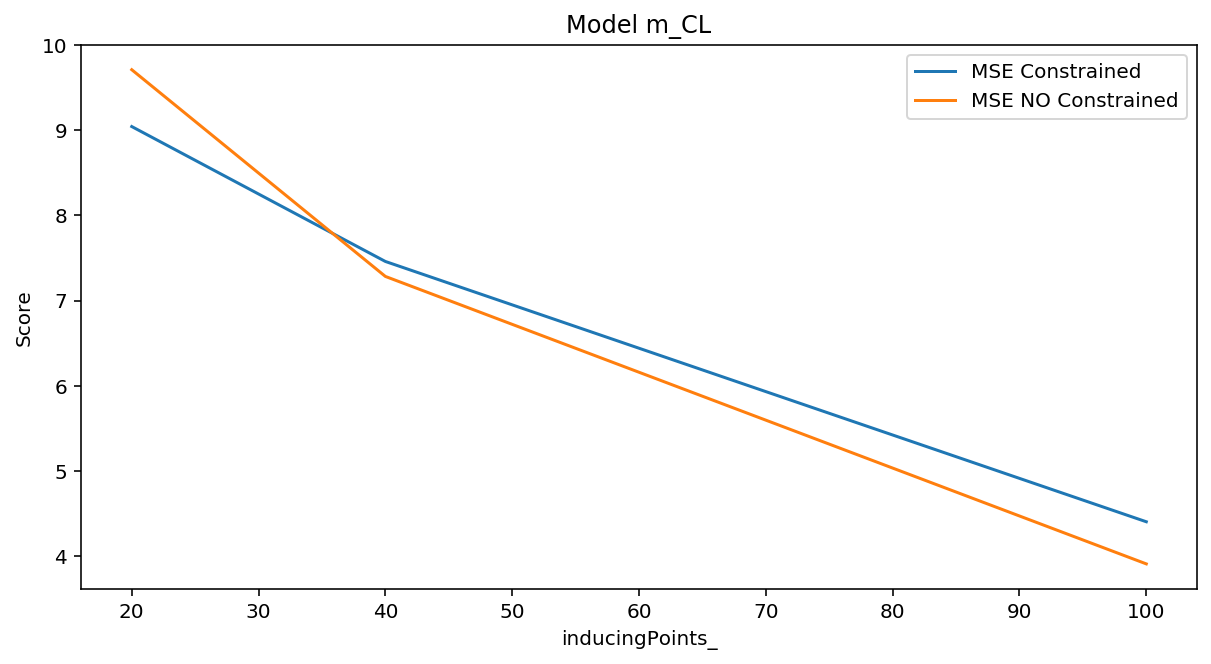

In [0]:
plt.figure(figsize=(10,5))
plt.plot(inducingPoints_, MSE_m_CL_X_before, label='MSE Constrained')
plt.plot(inducingPoints_, MSE_m_CL_X_after, label='MSE NO Constrained')
plt.xlabel('inducingPoints_')
plt.ylabel('Score')
plt.legend()
plt.title('Model m_CL')
plt.show()

In both cases, when using just 20 inducing points the results are better if the inducing points are not optimized. But it is quite strange as optimizing aims to provide better results. The reason could rely in the fact that the number of inducing points are not enought to be representative of the data, so optimization could not help. If we look at the results obtained using more inducing points, we could see lower errors after optimization. In fact, using 100 inducing points provided good results. Note that the resulting inducing points (the ones obtained after the optimization) are not points from the training dataset and that could explain why the performance could be a little bit worse if we look at the results of the previous section. Moreover, using Sparse GP helps a lot in reducing computational time. 

# BASURA -- BORRAR ANTES DE ENTREGAR

Comments

ARD: estimating the lengthscale parameters
`l1, `l2, ··· , `lD implicitly determines the relevance of each dimension. Take into account
that input dimensions with relatively large lengthscales imply relatively little variation
along those dimensions in the function being modeled.

BUSCADO EN INTERNET: *The length scale merely determines the idea of how close two data points are in a particular input dimension not how useful they are. 
If you want to figure out an importance of each feature first look at your kernel and decompose it by removing one dimension of x (i.e. remove a feature). Then determine the variance over you prediction space. Repeat for each dimension. **How 'important' a feature is can be see as how much it reduces the variance on predictions**.* 
**PREGUNTAR A PABLO SI ESTO ES LO QUE QUIERE!**


In [0]:
## NO BORRAR -- PREGUNTAR
# Samples the posterior GP at the points X_test
# posteriorYtest = m_HL.posterior_samples_f(X_test, full_cov=True, size=nsamples)

## Explanation of 20 Inducing points

We will explain each step briefly, to understand what is happening.

In [0]:
inducingPoints_ = 20

## SPARSE GAUSSIAN PROCESS
# GPy kernel: defaults to rbf+white
# num_inducing: number of inducing points
# If no Z array is passed, num_inducing points are selected from the data.
m_CL_20 = GPy.models.SparseGPRegression(X_train,Y_train[:, :1], num_inducing=inducingPoints_)
m_HL_20 = GPy.models.SparseGPRegression(X_train,Y_train[:, 1:], num_inducing=inducingPoints_)

Display the model refered to Heating Load we will see:

In [0]:
print('Display the model')
print(m_CL_20) 

Display the model

Name : sparse_gp
Objective : 52057.63729687393
Number of Parameters : 163
Number of Optimization Parameters : 163
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (20, 8)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        


Display the model refered to Cooling Load we will see:

In [0]:
print('Display the model')
print(m_HL_20) # preferred to display

Display the model

Name : sparse_gp
Objective : 51159.85281943498
Number of Parameters : 163
Number of Optimization Parameters : 163
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (20, 8)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        


The number of parameters corresponds to the following relationship:

> number of inducing points **x** input_dimension **+** rbf.variance **+**      rbf.lengthscale **+** Gaussian_noise.variance



> 20 **x** 8 **+** 1 **+** 1 **+** 1= 163





We can observe the inducing points the model has selected. Note that those points are from the dataset but have been randomly selected.

In [0]:
print('Intial inducing points for the model m_CL_20')
# print(m_CL_20.inducing_inputs)

print('Intial inducing points m_HL_20')
# print(m_HL_20.inducing_inputs)

Intial inducing points for the model m_CL_20
Intial inducing points m_HL_20


Fix a constraint related to the inducing points.
Constrain the inducing_inputs parameter to be fixed to the current value it carries. This does not override the previous constraints, so unfixing will restore the constraint set before fixing.

Note that the inducing points have been contraint and they wont change after the optimization.

In [0]:
m_CL_20.inducing_inputs.fix()
m_HL_20.inducing_inputs.fix()
print(m_HL_20)
# print(m_CL_20)


Name : sparse_gp
Objective : 51159.85281943498
Number of Parameters : 163
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (20, 8)  |     fixed     |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        


OPTIMIZING COVARIANCE PARAMETERS. It does NOT modify the induicing points as it have been fixed. Optimize the following parameters: rbf.variance, rbf.lengthscale, Gaussian_noise.variance.

In [0]:
m_HL_20.optimize_restarts(num_restarts = 5)
print(m_HL_20)

Optimization restart 1/5, f = 1595.5482956506676
Optimization restart 2/5, f = 1595.548276250458
Optimization restart 3/5, f = 1595.5483011484175
Optimization restart 4/5, f = 1595.548276288384
Optimization restart 5/5, f = 2878.2504072055763

Name : sparse_gp
Objective : 1595.548276250458
Number of Parameters : 163
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |             (20, 8)  |     fixed     |        
  rbf.variance             |  312.61620275271343  |      +ve      |        
  rbf.lengthscale          |   9.251058161671336  |      +ve      |        
  Gaussian_noise.variance  |   9.405821550892624  |      +ve      |        


In [0]:
m_CL_20.optimize_restarts(num_restarts = 5)
print(m_CL_20)

Optimization restart 1/5, f = 1505.8236571459165
Optimization restart 2/5, f = 1505.8236572370297
Optimization restart 3/5, f = 1505.8236571518355
Optimization restart 4/5, f = 1505.8236571471498
Optimization restart 5/5, f = 1505.8236571467642

Name : sparse_gp
Objective : 1505.8236571459165
Number of Parameters : 163
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |             (20, 8)  |     fixed     |        
  rbf.variance             |   592.5739801328707  |      +ve      |        
  rbf.lengthscale          |  11.293524998373732  |      +ve      |        
  Gaussian_noise.variance  |   6.932473486027257  |      +ve      |        


MSE ERROR: MODEL OPTIMIZED + NO CHANGES IN INDUCING POINTS

In [0]:
mu, var = m_CL_20.predict(X_test, full_cov=True) 
MSE_m_CL_20_after= metrics.mean_squared_error(y_test[:, :1], mu)
print(MSE_m_CL_20_after)

8.450763590716248


In [0]:
mu, var = m_HL_20.predict(X_test, full_cov=True) 
MSE_m_HL_20_after= metrics.mean_squared_error(y_test[:, 1:], mu)
print(MSE_m_HL_20_after)

9.674719703421545


OPTIMIZING INDUCING POINTS
Hablar del randomize y del uncontraint

In [0]:
m_CL_20.randomize()
m_HL_20.randomize()

# unconstrain() inducing_inputs
m_CL_20.Z.unconstrain() 
m_HL_20.Z.unconstrain() 

# m.optimize('bfgs', max_iters=1000)
m_CL_20.optimize_restarts(num_restarts = 5)
m_HL_20.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 1486.7541309225162
Optimization restart 2/5, f = 2830.619789237651
Optimization restart 3/5, f = 1487.2307223477
Optimization restart 4/5, f = 2830.6197921327935
Optimization restart 5/5, f = 1485.9060842532526
Optimization restart 1/5, f = 1585.3157123649762
Optimization restart 2/5, f = 1583.3993150669012
Optimization restart 3/5, f = 1583.2808127198405
Optimization restart 4/5, f = 1583.105569401887
Optimization restart 5/5, f = 2878.2504144285226


We could see that the inducing points have changed and the models have been optimized.

In [0]:
print('Intial inducing points for the model m_CL_20')
# print(m_CL_20.inducing_inputs)

print('Intial inducing points m_HL_20')
# print(m_HL_20.inducing_inputs)

Intial inducing points for the model m_CL_20
Intial inducing points m_HL_20


MSE ERROR: MODEL OPTIMIZED + CHANGES IN INDUCING POINTS

In [0]:
mu, var = m_CL_20.predict(X_test, full_cov=True) 
MSE_m_CL_20_before= metrics.mean_squared_error(y_test[:, :1], mu)
print(MSE_m_CL_20_before)

7.133974816692724


In [0]:
mu, var = m_HL_20.predict(X_test, full_cov=True) 
MSE_m_HL_20_before= metrics.mean_squared_error(y_test[:, 1:], mu)
print(MSE_m_HL_20_before)

8.840434387273064


https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/multiple%20outputs.ipynb

https://nbviewer.jupyter.org/url/gpss.cc/gpss18/labs/GPSS_Lab1_2018_Answers.ipynb

https://thegradient.pub/gaussian-process-not-quite-for-dummies/

http://gpss.cc/gprs15b/assets/session1.pdf

Vertical scale (VARAINCE): describes how much span the function has vertically;
Horizontal scale (LENGHTSCALE): describes how quickly the correlation between two points drops as the distance between them increases -- a high l gives you a smooth function, while lower l results in a wiggly function.

In [0]:
inducingPoints_ = [20, 40, 100]

MSE_m_CL_X_after= []
MSE_m_HL_X_after= []

MSE_m_CL_X_before= []
MSE_m_HL_X_before= []


for numInducingPoints in inducingPoints_: 

    print('')
    print('*************************************************')
    print('The number of inducing points is:', numInducingPoints)
    print('')

    ## SPARSE GAUSSIAN PROCESS
    # GPy kernel: defaults to rbf+white
    # num_inducing: number of inducing points
    # If no Z array is passed, num_inducing points are selected from the data.
    m_CL_X = GPy.models.SparseGPRegression(X_train,Y_train[:, :1], num_inducing=numInducingPoints)
    m_HL_X = GPy.models.SparseGPRegression(X_train,Y_train[:, 1:], num_inducing=numInducingPoints)

    ## FIX A CONTRAINT RELATED TO THE INDUCING POINTS
    # Constrain the inducing_inputs parameter to be fixed to the current value it carries.
    # This does not override the previous constraints, so unfixing will
    # restore the constraint set before fixing.
    m_CL_X.inducing_inputs.fix()
    m_HL_X.inducing_inputs.fix()

    ## OPTIMIZING COVARIANCE PARAMETERS
    # It does NOT modify the induicing points
    # Optimize the following parameters: rbf.variance, rbf.lengthscale, Gaussian_noise.variance
    print('Optimization - inducing points CONSTRAINED')
    print('                     model m_CL')
    m_CL_X.optimize_restarts(num_restarts = 5)
    print('                     model m_HL')
    m_HL_X.optimize_restarts(num_restarts = 5)

    ## MSE ERROR: MODEL OPTIMIZED + NO CHANGES IN INDUCING POINTS
    mu_CL, var = m_CL_X.predict(X_test, full_cov=True) 
    MSE_m_CL_X_after.append(metrics.mean_squared_error(y_test[:, :1], mu_CL))

    mu_HL, var = m_HL_X.predict(X_test, full_cov=True) 
    MSE_m_HL_X_after.append(metrics.mean_squared_error(y_test[:, 1:], mu_HL))

    ## OPTIMIZING INDUCING POINTS
    # randomize
    m_CL_X.inducing_inputs.randomize()
    m_HL_X.inducing_inputs.randomize()

    # m.Z.unconstrain() inducing_inputs
    m_CL_X.Z.unconstrain() 
    m_HL_X.Z.unconstrain()

    # optimize
    # .optimize('bfgs', max_iters=1000)
    print('')
    print('Optimization - inducing points NOT CONSTRAINED')
    print('                     model m_CL')
    m_CL_X.optimize_restarts(num_restarts = 5)
    print('                     model m_HL')
    m_HL_X.optimize_restarts(num_restarts = 5)

    ## MSE ERROR: MODEL OPTIMIZED + CHANGES IN INDUCING POINTS
    mu_CL, var = m_CL_X.predict(X_test, full_cov=True) 
    MSE_m_CL_X_before.append(metrics.mean_squared_error(y_test[:, :1], mu_CL))

    mu_HL, var = m_HL_X.predict(X_test, full_cov=True) 
    MSE_m_HL_X_before.append(metrics.mean_squared_error(y_test[:, 1:], mu_HL))


*************************************************
The number of inducing points is: 20

Optimization - inducing points CONSTRAINED
                     model m_CL
Optimization restart 1/5, f = 1503.968008304586
Optimization restart 2/5, f = 1503.968008305179
Optimization restart 3/5, f = 1503.968008305288
Optimization restart 4/5, f = 1503.9680083079547
Optimization restart 5/5, f = 1503.9680083420208
                     model m_HL
Optimization restart 1/5, f = 1629.088896187568
Optimization restart 2/5, f = 1629.0889050108162
Optimization restart 3/5, f = 2878.250429340853
Optimization restart 4/5, f = 1629.08889756415
Optimization restart 5/5, f = 1629.0889048303288

Optimization - inducing points NOT CONSTRAINED
                     model m_CL
Optimization restart 1/5, f = 1481.1068419281946
Optimization restart 2/5, f = 1485.3186568264027
Optimization restart 3/5, f = 1487.8022345857098
Optimization restart 4/5, f = 1486.8664347134982
Optimization restart 5/5, f = 1490.6442435437